# Navier Stokes in a pipe flow (stationary 2D) with hard constraints + Metamodel learning + HyperPINN

We solve the stationary Navier Stokes PDE:

$$
\begin{cases}
\nabla\cdot\mathbf{u}=0,\\
(\mathbf{u}\cdot\nabla)\mathbf{u} + \frac{1}{\rho}\nabla p - \theta \nabla^2\mathbf{u}=0.
\end{cases}
$$

This becomes in 2D, with $\mathbf{u}=\begin{pmatrix}u_x \\ u_y\end{pmatrix}$


$$
\begin{cases}
\frac{\partial}{\partial x} u_x + \frac{\partial}{\partial y} u_y = 0 \\
\begin{pmatrix}u_x\frac{\partial}{\partial x} u_x + u_y\frac{\partial}{\partial y} u_x \\
u_x\frac{\partial}{\partial x} u_y + u_y\frac{\partial}{\partial y} u_y  \end{pmatrix} +
\frac{1}{\rho} \begin{pmatrix} \frac{\partial}{\partial x} p \\ \frac{\partial}{\partial y} p \end{pmatrix}
- \theta
\begin{pmatrix}
\frac{\partial^2}{\partial x^2} u_x + \frac{\partial^2}{\partial y^2} u_x \\
\frac{\partial^2}{\partial x^2} u_y + \frac{\partial^2}{\partial y^2} u_y
\end{pmatrix} = 0\\
\end{cases}
$$


With the boundary condition:
$$
\begin{cases}
u(x, \frac{d}{2}) = -u(x, \frac{d}{2})=0, \forall x \text{ (boundary condition) }\\
p(x_{min}, y)=0 \text{ and } p(x_{max}, y)=0.1, \forall y \text{ (boundary condition) }
\end{cases}
$$

The domain is defined with $x\in[0,L]$ and $y\in[-R, R]$. __Note__ that because of the central symmetry with respect to the centerline of the tube, we only consider the $y$ axis which will represent the cross section

This notebook aims at reproducing the example of section 3.1 of [*Surrogate modeling for fluid flows based on physics-constrained deep learning without simulation data*, Sun et al. 2020](https://www.sciencedirect.com/science/article/pii/S004578251930622X), __including the introduction of a *metamodel*, i.e., a parameter from the equation $\theta$, is itself input of the neural network and we learn a solution $\forall \theta$.__

__We also compare the metamodeling using an HyperPINN [HyperPINN: Learning parameterized differential equations with physics-informed hypernetworks](https://arxiv.org/pdf/2111.01008.pdf)__

## 1 )Metamodeling with a classical PINN
In this case, the equation parameter $\theta$ is also fed to the same NN as $x$ (i.e., in the main PINN). This is done by a dedicated `input_transform`, see below.
The HyperPINN relies on another strategy (see last section)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create a DataGenerator object and set up some geometry. Following the [authors' implementation](https://github.com/Jianxun-Wang/LabelFree-DNN-Surrogate/blob/master/Tutorial/PipeFlow.ipynb), we set a pipe length $L=1$ and a pipe radius$R=0.05$. Following the authors, we also simplify the problem because of its geometry: the solution is symmetric with respect to the center of the pipe, at a given point $x\in[0, L]$. Therefore we only need one axis representing a pipe cross section and one axis representing the pipe length.

In [4]:
L = 1
R = 0.05

p_out = 0
p_in = 0.1

In [5]:
n = 10000
nb = None
omega_batch_size = 128
omega_border_batch_size = None
dim = 2
xmin = 0
xmax = xmin + L
ymin = -R
ymax = ymin + 2 * R
# zmin = -R
# zmax = zmin + 2 * R

__Note:__ that we choose a very simple data generator and no boundary condition despite the pipe-like geometry. Indeed, we choose to follow the author's hard coded boundary constraints. The neural network outputs are then multiplied with a factor which enforces the constraints. We impose the so-called _slip-condition_ on the borders, ie, the fluid has a null speed on the borders.

Create the neural network architecture for the PINN with `equinox`. We have a PINN which outputs the velocity field `u` (2D output) and concatenated to the pressure field `p` (1D output). So the total PINN output is of size 3. The PINN input is 3 because we append the value of the parameter $\theta$ for metamodeling.

**Note the input transform which is fundamental to the metamodel, this is where the hyperparameters are fed to the PINN and this function must be provided by the user as shown below.**


The `output_transform` function enforces the *hardly* boundary conditions.

In [6]:
key, subkey = random.split(key)


def u_p_output_transform(pinn_in, pinn_out, params):
    return jnp.concatenate(
        [
            pinn_out[0:2] * (R**2 - pinn_in[1] ** 2),
            (pinn_in[0] - xmin) / (xmax - xmin) * p_out
            + (xmax - pinn_in[0]) / (xmax - xmin) * p_in
            + (xmin - pinn_in[0]) * (xmax - pinn_in[0]) * pinn_out[2:3],
        ],
        axis=-1,
    )


def u_p_input_transform(x, params):
    # Here we know we will have batches of nu parameters and we feed it to the PINN
    return jnp.concatenate([x, params.eq_params["nu"]], axis=-1)


u_p, u_p_init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey,
    eqx_list=(
        (eqx.nn.Linear, 3, 50),
        (jax.nn.swish,),
        (eqx.nn.Linear, 50, 50),
        (jax.nn.swish,),
        (eqx.nn.Linear, 50, 50),
        (jax.nn.swish,),
        (eqx.nn.Linear, 50, 50),
        (jax.nn.swish,),
        (eqx.nn.Linear, 50, 3),
    ),
    eq_type="statio_PDE",
    output_transform=u_p_output_transform,
    input_transform=u_p_input_transform,
)

Plot the initial PINN outputs

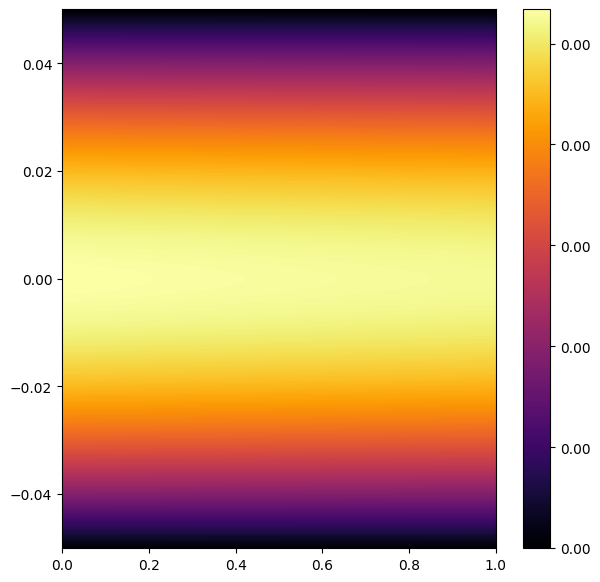

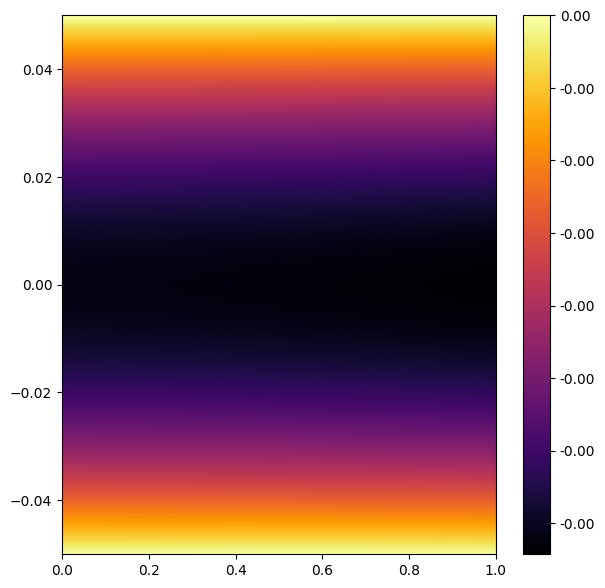

In [7]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]

u_xinit = lambda x: u_p(
    x,
    jinns.parameters.Params(
        nn_params=u_p_init_nn_params,
        eq_params={"rho": 1.0, "nu": jnp.array([0.0004])},
    ),
)[0]
jinns.plot.plot2d(fun=u_xinit, xy_data=val_xy_data, title="u_init(x)")

u_yinit = lambda x: u_p(
    x,
    jinns.parameters.Params(
        nn_params=u_p_init_nn_params,
        eq_params={"rho": 1.0, "nu": jnp.array([0.0004])},
    ),
)[1]
jinns.plot.plot2d(fun=u_yinit, xy_data=val_xy_data, title="u_init(y)")

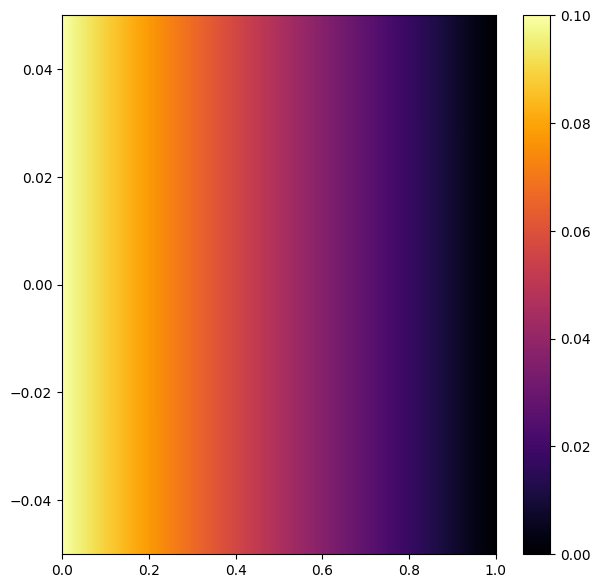

In [8]:
jinns.plot.plot2d(
    fun=lambda x: u_p(
        x,
        jinns.parameters.Params(
            nn_params=u_p_init_nn_params,
            eq_params={"rho": 1.0, "nu": jnp.array([0.0004])},
        ),
    )[2],
    xy_data=val_xy_data,
    title="p(x, y)",
)

Data generator creation

In [9]:
method = "uniform"
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    method=method,
)

Here we create another data generator for the equation parameter $\theta$. The class is simple to use but we require that the batch size for such generator be the same of the other generator !

In [10]:
method = "grid"
key, subkey = random.split(key)
np = 1000
param_batch_size = 128  # must be equal to batch size of the main DataGenerator
param_train_data = jinns.data.DataGeneratorParameter(
    subkey,
    np,
    param_batch_size,
    {"nu": (2e-4, 1.9e-3)},
    method,
)

## Model parameters

Here we set the density $\rho=1$ and we simplify the problem with respect to the article: $\theta$ is the viscosity parameter, __it is not fixed here but a solution is learnt $\forall \theta$ in a given interval__.

In [11]:
rho = 1.0
# nu = 0.00061

Delta_p = 0.1
d = 2 * R

In [12]:
param_train_data, param_batch = param_train_data.get_batch()
init_params = jinns.parameters.Params(
    nn_params=u_p_init_nn_params,
    eq_params={"rho": rho, **param_batch},
)

## Analytical solution
In this case, the analytical solution is known:
$$
u_a = \frac{\Delta p}{2\theta\rho L}(\frac{d^2}{4} - y^2)
$$

Text(0.5, 1.0, 'True solution along a cross section')

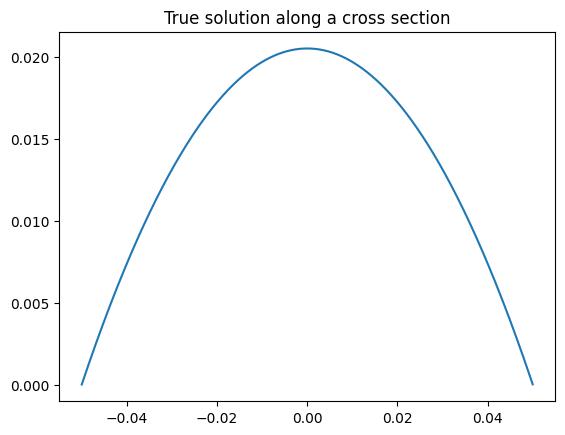

In [13]:
def u_true(y, nu=0.0061):
    return Delta_p / (2 * nu * rho * L) * ((d / 2) ** 2 - y**2)


plt.plot(
    train_data.omega[:, 1].sort(axis=0),
    vmap(u_true, (0), 0)(train_data.omega[:, 1].sort(axis=0)),
)
plt.title(r"True solution along a cross section")

## Loss construction

In [14]:
dyn_loss = jinns.loss.NavierStokesMassConservation2DStatio()

In [15]:
loss_weights = jinns.loss.LossWeightsPDEStatio(dyn_loss=1.0)

loss = jinns.loss.LossPDEStatio(
    u=u_p, loss_weights=loss_weights, dynamic_loss=dyn_loss, params=init_params
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:181: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


Note that we need to concatenate the two batches from the two data generator, this is particular for this metamodel learning procedure. However, this procedure will be transparent in the rest of the optimization.

In [16]:
from jinns.data import append_param_batch

# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
train_data, batch = train_data.get_batch()
param_train_data, param_batch = param_train_data.get_batch()
losses, grads = losses_and_grad(
    init_params, batch=append_param_batch(batch, param_batch)
)


l_tot, dict_losses = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in dict_losses.items()} }")

total loss: 0.01
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '0.01', 'norm_loss': '0.00', 'observations': '0.00'}


## Validation loss for PINN

In [17]:
key, subkey = random.split(key)
validation_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    omega_batch_size=1000,
    omega_border_batch_size=None,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    method="uniform",
)

In [18]:
key, subkey = random.split(key)
np = 10000
param_batch_size = (
    1000  # must be equal to batch size of the main validation DataGenerator
)
validation_param_data = jinns.data.DataGeneratorParameter(
    subkey,
    np,
    param_batch_size,
    {"nu": (2e-4, 1.9e-3)},
    method="grid",
)

In [19]:
from jinns.validation import ValidationLoss

validation = ValidationLoss(
    loss=loss,
    validation_data=validation_data,
    validation_param_data=validation_param_data,
    validation_obs_data=None,
    call_every=500,
    early_stopping=True,
    patience=20,
)

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [20]:
params = init_params

In [21]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=1e-3)

In [22]:
n_iter = 50000

In [23]:
(
    params,
    total_loss_list,
    loss_by_term_dict,
    train_data,
    loss,
    _,
    _,
    _,
    validation_loss_values,
    validation_best_params,
) = jinns.solve(
    init_params=params,
    data=train_data,
    param_data=param_train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    validation=validation,
)


Compilation took
 12.825808763504028 

[validation] Iteration 0: loss value = 0.00996868684887886
[train] Iteration 0: loss value = 0.009921307675540447
[validation] Iteration 1000: loss value = 0.0018057089764624834
[train] Iteration 1000: loss value = 0.0018105360213667154
[validation] Iteration 2000: loss value = 0.001907214755192399
[train] Iteration 2000: loss value = 0.0018030519131571054
[validation] Iteration 3000: loss value = 0.0017410691361874342
[train] Iteration 3000: loss value = 0.0018733346369117498
[validation] Iteration 4000: loss value = 0.001791859045624733
[train] Iteration 4000: loss value = 0.001833117101341486
[validation] Iteration 5000: loss value = 0.001713913632556796
[train] Iteration 5000: loss value = 0.0016288446495309472
[validation] Iteration 6000: loss value = 0.0006285494891926646
[train] Iteration 6000: loss value = 0.0006002428126521409
[validation] Iteration 7000: loss value = 0.0004998401855118573
[train] Iteration 7000: loss value = 0.000548841

## Results

Plot the loss values

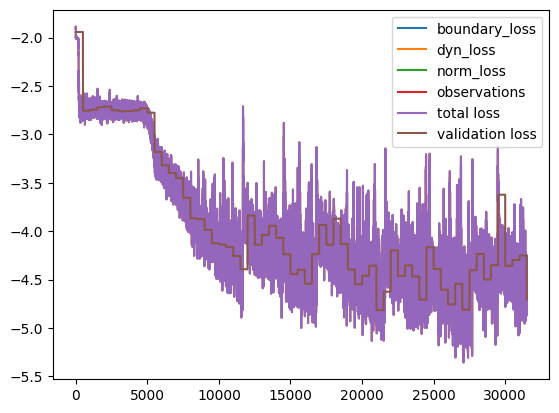

In [30]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.plot(jnp.log10(validation_loss_values), label="validation loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN. Note that we need to fix $\theta$ to certain values.

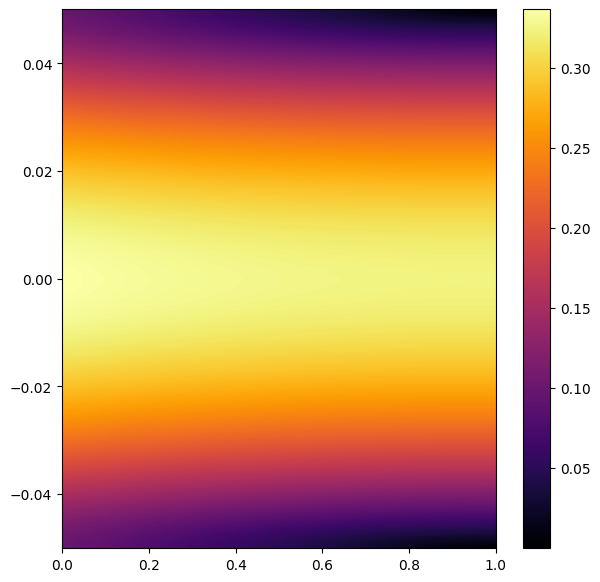

In [32]:
jinns.plot.plot2d(
    fun=lambda x: jnp.linalg.norm(
        u_p(
            x,
            jinns.parameters.Params(
                nn_params=validation_best_params.nn_params,
                eq_params={"rho": 1.0, "nu": jnp.array([0.0004])},
            ),
        )
    ),
    xy_data=val_xy_data,
    title="||u_est(x ,y)||",
)

We now plot some slices for fixed $\theta$ along with the true solution.

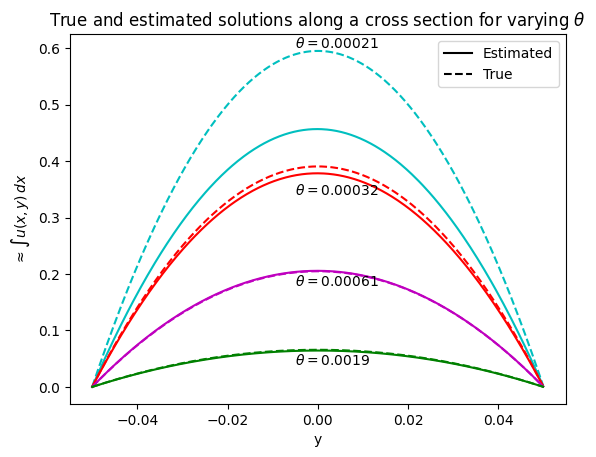

In [34]:
v_u_est_y_nu = lambda x, y_j, nu: vmap(
    # compute average over array x with y_j fixed.
    lambda x, y_j: vmap(
        lambda z: u_p(
            jnp.stack([z, y_j], axis=-1),
            jinns.parameters.Params(
                nn_params=validation_best_params.nn_params,
                eq_params={"rho": rho, "nu": jnp.array([nu])},
            ),
        )[0],
        0,
        0,
    )(x).mean(),
    (None, 0),
    0,
)(x, y_j)

for nu, c in zip([0.00021, 0.00032, 0.00061, 0.0019], ["c", "r", "m", "g"]):
    plt.plot(
        train_data.omega[::10, 1].sort(axis=0),
        v_u_est_y_nu(
            train_data.omega[::10, 0].sort(axis=0),
            train_data.omega[::10, 1].sort(axis=0),
            nu,
        ),
        c,
    )

    plt.plot(
        train_data.omega[::10, 1].sort(axis=0),
        vmap(lambda x: u_true(x, nu=nu), (0), 0)(
            train_data.omega[::10, 1].sort(axis=0)
        ),
        c + "--",
    )

plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
(line1,) = plt.plot([0], "k", label="Estimated")
(line2,) = plt.plot([0], "k--", label="True")
plt.text(-0.005, 0.6, r"$\theta=0.00021$")
plt.text(-0.005, 0.34, r"$\theta=0.00032$")
plt.text(-0.005, 0.18, r"$\theta=0.00061$")
plt.text(-0.005, 0.04, r"$\theta=0.0019$")
plt.legend(handles=[line1, line2])
plt.title(r"True and estimated solutions along a cross section for varying $\theta$")
plt.show()

## 2) Metamodeling with an HyperPINN

We solve the same problem with an HyperPINN as provided by **jinns** and compare the two approaches

In [33]:
def u_p_output_transform(pinn_in, pinn_out, params):
    return jnp.concatenate(
        [
            pinn_out[0:2] * (R**2 - pinn_in[1] ** 2),
            (pinn_in[0] - xmin) / (xmax - xmin) * p_out
            + (xmax - pinn_in[0]) / (xmax - xmin) * p_in
            + (xmin - pinn_in[0]) * (xmax - pinn_in[0]) * pinn_out[2:3],
        ],
        axis=-1,
    )


eqx_list = (
    (eqx.nn.Linear, 2, 50),
    (jax.nn.swish,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.swish,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.swish,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.swish,),
    (eqx.nn.Linear, 50, 3),
)

eqx_list_hyper = (
    (eqx.nn.Linear, 1, 32),  # input is of size 1 for scalar viscosity nu
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (
        eqx.nn.Linear,
        32,
        1000,
    ),  # 1000 is a random guess, it will automatically be filled with the correct value
)

key, subkey = random.split(key)
hyperparams = ["nu"]
hypernet_input_size = 1
u_p_hyper, u_p_init_nn_params = jinns.nn.HyperPINN.create(
    key=subkey,
    eqx_list=eqx_list,
    eq_type="statio_PDE",
    hyperparams=hyperparams,
    hypernet_input_size=hypernet_input_size,
    eqx_list_hyper=eqx_list_hyper,
    output_transform=u_p_output_transform,
)

In [34]:
param_train_data, param_batch = param_train_data.get_batch()
init_params_hyper = jinns.parameters.Params(
    nn_params=u_p_init_nn_params,
    eq_params={"rho": rho, **param_batch},
)

In [35]:
loss_weights = jinns.loss.LossWeightsPDEStatio(dyn_loss=1.0)

loss_hyper = jinns.loss.LossPDEStatio(
    u=u_p_hyper,
    loss_weights=loss_weights,
    dynamic_loss=dyn_loss,
    params=init_params_hyper,
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:181: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


## Validation loss for HyperPINN

We use the same `validation_data` and `validation_param_data` as created in the PINN section.

In [36]:
from jinns.validation import ValidationLoss

validation_hyper = ValidationLoss(
    loss=loss_hyper,
    validation_data=validation_data,
    validation_param_data=validation_param_data,
    validation_obs_data=None,
    call_every=500,
    early_stopping=True,
    patience=20,
)

In [37]:
params_hyper = init_params_hyper

In [38]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=5e-4)

In [39]:
n_iter = 45000
(
    params_hyper,
    total_loss_list_hyper,
    loss_by_term_dict_hyper,
    train_data,
    loss_hyper,
    _,
    _,
    _,
    validation_loss_values_hyper,
    validation_best_params_hyper,
) = jinns.solve(
    init_params=params_hyper,
    data=train_data,
    param_data=param_train_data,
    optimizer=tx,
    loss=loss_hyper,
    n_iter=n_iter,
    validation=validation_hyper,
)


Compilation took
 18.687586545944214 

[validation] Iteration 0: loss value = 0.011278401128947735
[train] Iteration 0: loss value = 0.010108767077326775
[validation] Iteration 1000: loss value = 0.0018489635549485683
[train] Iteration 1000: loss value = 0.0016867375234141946
[validation] Iteration 2000: loss value = 0.00222793105058372
[train] Iteration 2000: loss value = 0.0022782261949032545
[validation] Iteration 3000: loss value = 0.0017481317045167089
[train] Iteration 3000: loss value = 0.001860371557995677
[validation] Iteration 4000: loss value = 0.0018605220830067992
[train] Iteration 4000: loss value = 0.002061711624264717
[validation] Iteration 5000: loss value = 0.0019280929118394852
[train] Iteration 5000: loss value = 0.0018246264662593603
[validation] Iteration 6000: loss value = 0.0018224735977128148
[train] Iteration 6000: loss value = 0.002007167786359787
[validation] Iteration 7000: loss value = 0.0029437891207635403
[train] Iteration 7000: loss value = 0.001787861

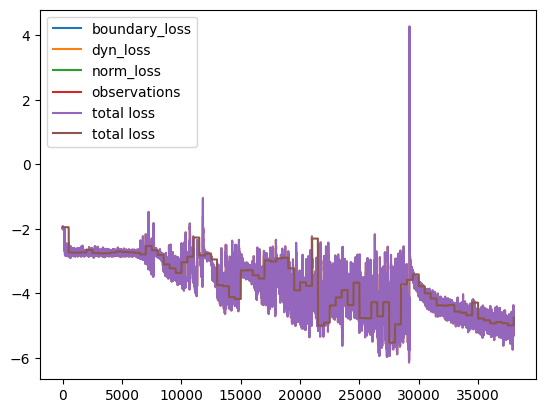

In [40]:
for loss_name, loss_values in loss_by_term_dict_hyper.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_hyper), label="total loss")
plt.plot(jnp.log10(validation_loss_values_hyper), label="total loss")
plt.legend()
plt.show();

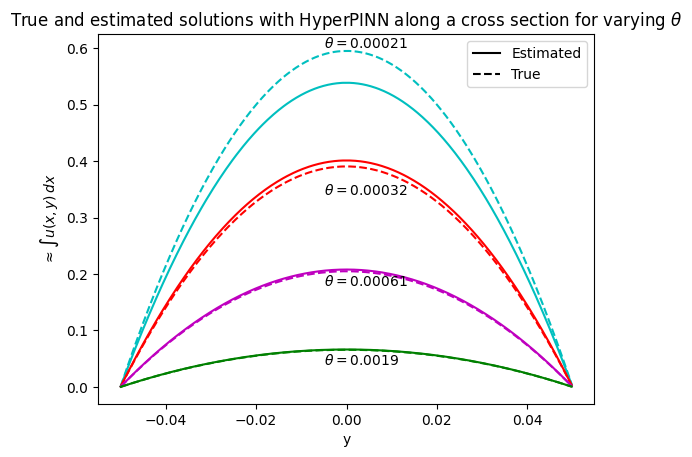

In [42]:
# import matplotlib

# matplotlib.rcParams.update({"font.size": 12})

v_u_est_y_nu_hyper = lambda x, y_j, nu: vmap(
    # compute average over array x with y_j fixed.
    lambda x, y_j: vmap(
        lambda z: u_p_hyper(
            jnp.stack([z, y_j], axis=-1),
            jinns.parameters.Params(
                nn_params=validation_best_params_hyper.nn_params,
                eq_params={"rho": rho, "nu": jnp.array([nu])},
            ),
        )[0],
        0,
        0,
    )(x).mean(),
    (None, 0),
    0,
)(x, y_j)

for nu, c in zip([0.00021, 0.00032, 0.00061, 0.0019], ["c", "r", "m", "g"]):
    plt.plot(
        train_data.omega[::10, 1].sort(axis=0),
        v_u_est_y_nu_hyper(
            train_data.omega[::10, 0].sort(axis=0),
            train_data.omega[::10, 1].sort(axis=0),
            nu,
        ),
        c,
    )

    plt.plot(
        train_data.omega[::10, 1].sort(axis=0),
        vmap(lambda x: u_true(x, nu=nu), (0), 0)(
            train_data.omega[::10, 1].sort(axis=0)
        ),
        c + "--",
    )

plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
(line1,) = plt.plot([0], "k", label="Estimated")
(line2,) = plt.plot([0], "k--", label="True")
plt.text(-0.005, 0.6, r"$\theta=0.00021$")
plt.text(-0.005, 0.34, r"$\theta=0.00032$")
plt.text(-0.005, 0.18, r"$\theta=0.00061$")
plt.text(-0.005, 0.04, r"$\theta=0.0019$")
plt.legend(handles=[line1, line2])
plt.title(
    r"True and estimated solutions with HyperPINN along a cross section for varying $\theta$"
)
# plt.savefig("NS_pipeflow_metamodel.png", transparent=True)
plt.show()

## 3) Conclusion

When allocated the same number of iterations, both approaches gives approximately the same estimation, and it is hard to favor one or the other approach on this problem.